<a href="https://colab.research.google.com/github/ayshekazimova/DL-Exam-Task11-Aysen-Kazimova/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Device: cpu


100%|██████████| 9.91M/9.91M [00:00<00:00, 58.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.71MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 16.5MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.27MB/s]



Training Version 1 (No Augmentation)
Epoch [1/10] Accuracy: 93.54%
Epoch [2/10] Accuracy: 97.64%
Epoch [3/10] Accuracy: 98.17%
Epoch [4/10] Accuracy: 98.43%
Epoch [5/10] Accuracy: 98.77%
Epoch [6/10] Accuracy: 98.87%
Epoch [7/10] Accuracy: 99.03%
Epoch [8/10] Accuracy: 99.10%
Epoch [9/10] Accuracy: 99.20%
Epoch [10/10] Accuracy: 99.31%
Version 1 Test Accuracy: 99.22

Training Version 2 (With Augmentation)
Epoch [1/10] Accuracy: 87.02%
Epoch [2/10] Accuracy: 94.98%
Epoch [3/10] Accuracy: 96.06%
Epoch [4/10] Accuracy: 96.73%
Epoch [5/10] Accuracy: 97.09%
Epoch [6/10] Accuracy: 97.41%
Epoch [7/10] Accuracy: 97.67%
Epoch [8/10] Accuracy: 97.69%
Epoch [9/10] Accuracy: 97.77%
Epoch [10/10] Accuracy: 97.95%
Version 2 Test Accuracy: 99.42


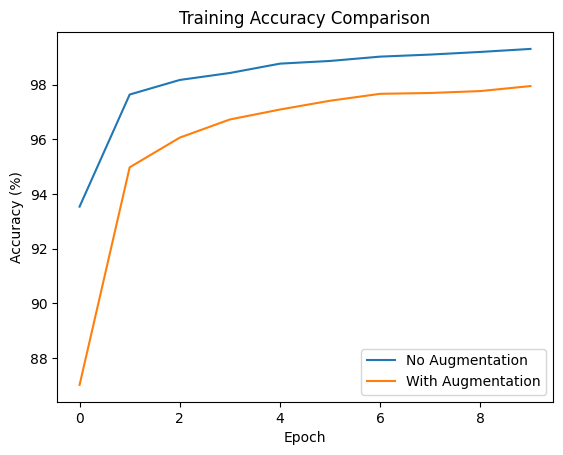

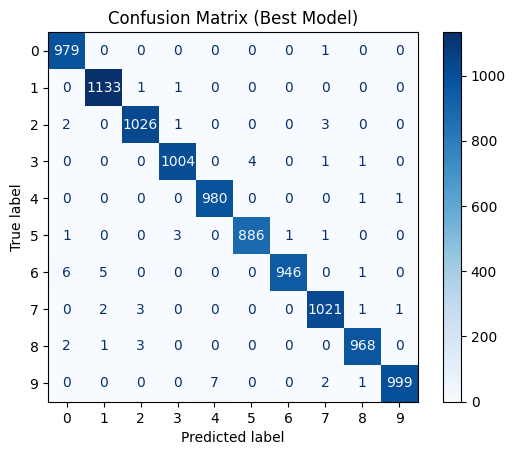

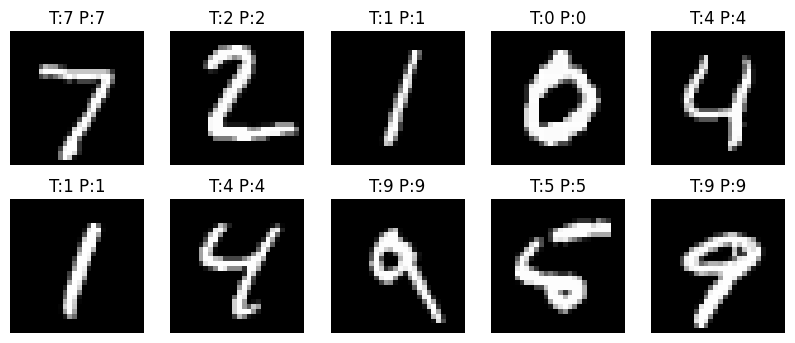


FINAL RESULTS
Version 1 Accuracy: 99.22%
Version 2 Accuracy: 99.42%
Best Model: With Augmentation


In [1]:
# ===============================
# IMPORTS
# ===============================
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ===============================
# SEED SETUP (REQUIRED)
# ===============================
SEED = 20240211
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ===============================
# DATA TRANSFORMS
# ===============================

# Version 1: No Augmentation
transform_v1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Version 2: With Augmentation
transform_v2 = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# ===============================
# DATASETS & LOADERS
# ===============================
train_dataset_v1 = datasets.MNIST(
    root="./data", train=True, download=True, transform=transform_v1
)

train_dataset_v2 = datasets.MNIST(
    root="./data", train=True, download=True, transform=transform_v2
)

test_dataset = datasets.MNIST(
    root="./data", train=False, download=True, transform=transform_v1
)

train_loader_v1 = DataLoader(train_dataset_v1, batch_size=64, shuffle=True)
train_loader_v2 = DataLoader(train_dataset_v2, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# ===============================
# MODEL DEFINITION (EXACT ARCH)
# ===============================
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# ===============================
# TRAIN & EVALUATE FUNCTIONS
# ===============================
def train_model(model, loader, optimizer, criterion, epochs=10):
    model.train()
    train_acc = []

    for epoch in range(epochs):
        correct, total = 0, 0
        for x, y in loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(out, 1)
            correct += (preds == y).sum().item()
            total += y.size(0)

        acc = 100 * correct / total
        train_acc.append(acc)
        print(f"Epoch [{epoch+1}/{epochs}] Accuracy: {acc:.2f}%")

    return train_acc

def evaluate_model(model, loader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            _, preds = torch.max(out, 1)

            correct += (preds == y).sum().item()
            total += y.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    acc = 100 * correct / total
    return acc, np.array(all_labels), np.array(all_preds)

# ===============================
# VERSION 1 TRAINING
# ===============================
model_v1 = CNN().to(device)
optimizer_v1 = optim.Adam(model_v1.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

print("\nTraining Version 1 (No Augmentation)")
acc_v1_curve = train_model(model_v1, train_loader_v1, optimizer_v1, criterion)

test_acc_v1, y_true_v1, y_pred_v1 = evaluate_model(model_v1, test_loader)
print("Version 1 Test Accuracy:", test_acc_v1)

# ===============================
# VERSION 2 TRAINING
# ===============================
model_v2 = CNN().to(device)
optimizer_v2 = optim.Adam(model_v2.parameters(), lr=0.001)

print("\nTraining Version 2 (With Augmentation)")
acc_v2_curve = train_model(model_v2, train_loader_v2, optimizer_v2, criterion)

test_acc_v2, y_true_v2, y_pred_v2 = evaluate_model(model_v2, test_loader)
print("Version 2 Test Accuracy:", test_acc_v2)

# ===============================
# TRAINING COMPARISON PLOT
# ===============================
plt.figure()
plt.plot(acc_v1_curve, label="No Augmentation")
plt.plot(acc_v2_curve, label="With Augmentation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy Comparison")
plt.legend()
plt.show()

# ===============================
# CONFUSION MATRIX (BEST MODEL)
# ===============================
best_labels = y_true_v2 if test_acc_v2 > test_acc_v1 else y_true_v1
best_preds  = y_pred_v2 if test_acc_v2 > test_acc_v1 else y_pred_v1

cm = confusion_matrix(best_labels, best_preds)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Best Model)")
plt.show()

# ===============================
# SAMPLE PREDICTIONS (10)
# ===============================
model_best = model_v2 if test_acc_v2 > test_acc_v1 else model_v1
model_best.eval()

images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model_best(images)
    _, preds = torch.max(outputs, 1)

plt.figure(figsize=(10,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(images[i].cpu().squeeze(), cmap="gray")
    plt.title(f"T:{labels[i].item()} P:{preds[i].item()}")
    plt.axis("off")
plt.show()

# ===============================
# FINAL RESULTS
# ===============================
print("\nFINAL RESULTS")
print(f"Version 1 Accuracy: {test_acc_v1:.2f}%")
print(f"Version 2 Accuracy: {test_acc_v2:.2f}%")
print("Best Model:", "With Augmentation" if test_acc_v2 > test_acc_v1 else "No Augmentation")
